🎯 Modélisation Avancée - predection de Churn Bancaire

📋 Projet MLOps - 3 IDSD ID
Objectif: Expérimentation, Fine-tuning et Stacking de modèles ML pour la détection de fraudes

Modèles de base:

Random Forest
XGBoost
LightGBM
CatBoost
Pipeline:

Entraînement des modèles de base
Fine-tuning avec RandomizedSearchCV
Stacking Ensemble
Comparaison complète

1. 📦 Imports et Configuration

In [2]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Machine Learning - Optimisation
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform

# Machine Learning - Évaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuration des graphiques
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

2. 📁 Chargement des Données Preprocessées

In [3]:
# Définir le chemin vers les processeurs
PROCESSOR_DIR = 'processors'  # Adapter selon votre structure

def load_preprocessed_data(processor_dir=PROCESSOR_DIR):
    """
    Charge les données preprocessées et les processeurs
    """
    print(f"{'='*80}")
    print("CHARGEMENT DES DONNÉES PREPROCESSÉES")
    print(f"{'='*80}")
    
    # Charger les données
    data_path = os.path.join(processor_dir, 'preprocessed_data.pkl')
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    print(f"✅ Données chargées:")
    print(f"   • X_train: {X_train.shape}")
    print(f"   • X_test:  {X_test.shape}")
    print(f"   • y_train: {y_train.shape}")
    print(f"   • y_test:  {y_test.shape}")
    
    # Charger les processeurs
    processors = {}
    processor_files = ['scaler.pkl', 'label_encoders.pkl', 'feature_names.pkl', 'smote_config.pkl']
    
    print(f"\n✅ Processeurs chargés:")
    for filename in processor_files:
        filepath = os.path.join(processor_dir, filename)
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                processors[filename.replace('.pkl', '')] = pickle.load(f)
            print(f"   • {filename}")
    
    # Statistiques sur les classes
    print(f"\n📊 Distribution des classes:")
    print(f"   • Train - Churn: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
    print(f"   • Train - Normal: {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean())*100:.2f}%)")
    print(f"   • Test  - Churn: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
    print(f"   • Test  - Normal: {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean())*100:.2f}%)")
    
    return X_train, X_test, y_train, y_test, processors

# Charger les données
X_train, X_test, y_train, y_test, processors = load_preprocessed_data()

CHARGEMENT DES DONNÉES PREPROCESSÉES
✅ Données chargées:
   • X_train: (42070, 40)
   • X_test:  (6000, 40)
   • y_train: (42070,)
   • y_test:  (6000,)

✅ Processeurs chargés:
   • scaler.pkl
   • label_encoders.pkl
   • feature_names.pkl
   • smote_config.pkl

📊 Distribution des classes:
   • Train - Churn: 21,035 (50.00%)
   • Train - Normal: 21,035 (50.00%)
   • Test  - Churn: 741 (12.35%)
   • Test  - Normal: 5,259 (87.65%)


3. 🤖 Phase 1: Modèles de Base (Baseline)

In [4]:
def initialize_baseline_models():
    """
    Initialise les modèles de base avec des configurations optimisées
    pour la détection de fraude
    """
    print(f"{'='*80}")
    print("🚀 INITIALISATION DES MODÈLES BASELINE")
    print(f"{'='*80}\n")
    
    # Calcul du ratio de déséquilibre des classes
    fraud_ratio = y_train.sum() / len(y_train)
    scale_pos = (1 - fraud_ratio) / fraud_ratio
    
    print(f"📊 Ratio de déséquilibre calculé: {scale_pos:.2f}")
    print(f"   → Sera utilisé pour pondérer les classes\n")
    
    baseline_config = {
        'XGBoost': XGBClassifier(
            n_estimators=150,
            max_depth=7,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,
            scale_pos_weight=scale_pos,
            random_state=42,
            eval_metric='auc',
            use_label_encoder=False,
            tree_method='hist'
        ),
        
        'LightGBM': LGBMClassifier(
            n_estimators=150,
            max_depth=8,
            learning_rate=0.05,
            num_leaves=40,
            min_child_samples=25,
            subsample=0.85,
            colsample_bytree=0.85,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1,
            importance_type='gain'
        ),
        
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=25,
            min_samples_split=15,
            min_samples_leaf=5,
            max_features='sqrt',
            class_weight='balanced_subsample',
            bootstrap=True,
            random_state=42,
            n_jobs=-1,
            warm_start=False
        ),
        
        'CatBoost': CatBoostClassifier(
            iterations=150,
            depth=7,
            learning_rate=0.05,
            l2_leaf_reg=3,
            border_count=128,
            auto_class_weights='Balanced',
            random_state=42,
            verbose=False,
            task_type='CPU',
            bootstrap_type='Bernoulli',
            subsample=0.85
        ),
        
        'Logistic Regression (ElasticNet)': LogisticRegression(
            penalty='elasticnet',
            C=1.0,
            l1_ratio=0.5,
            solver='saga',
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            warm_start=False
        )
    }
    
    print("✅ Modèles configurés:\n")
    for idx, (model_name, model) in enumerate(baseline_config.items(), 1):
        print(f"   {idx}. {model_name}")
        if hasattr(model, 'n_estimators'):
            print(f"      └─ Estimateurs: {model.n_estimators}")
        elif hasattr(model, 'iterations'):
            print(f"      └─ Itérations: {model.iterations}")
    
    print(f"\n{'='*80}\n")
    return baseline_config

# Initialiser les modèles
baseline_models = initialize_baseline_models()

🚀 INITIALISATION DES MODÈLES BASELINE

📊 Ratio de déséquilibre calculé: 1.00
   → Sera utilisé pour pondérer les classes

✅ Modèles configurés:

   1. XGBoost
      └─ Estimateurs: 150
   2. LightGBM
      └─ Estimateurs: 150
   3. Random Forest
      └─ Estimateurs: 200
   4. CatBoost
   5. Logistic Regression (ElasticNet)




# 4. 🏋️ Entraînement des Modèles Baseline


In [5]:
def train_baseline_models(models_dict, X_train, y_train, X_test, y_test):
    """
    Entraîne et évalue chaque modèle baseline avec tracking détaillé
    """
    print(f"{'='*80}")
    print("🎯 PHASE D'ENTRAÎNEMENT - MODÈLES BASELINE")
    print(f"{'='*80}\n")
    
    performance_tracker = {}
    
    for model_idx, (model_name, model_instance) in enumerate(models_dict.items(), 1):
        print(f"┌{'─'*78}┐")
        print(f"│ [{model_idx}/{len(models_dict)}] Entraînement: {model_name:<60} │")
        print(f"└{'─'*78}┘")
        
        # Mesure du temps d'entraînement
        start = time.time()
        
        try:
            # Entraînement
            model_instance.fit(X_train, y_train)
            train_duration = time.time() - start
            
            # Prédictions sur l'ensemble de test
            predictions = model_instance.predict(X_test)
            predictions_proba = model_instance.predict_proba(X_test)[:, 1]
            
            # Calcul des métriques de performance
            metrics = {
                'model_object': model_instance,
                'accuracy': accuracy_score(y_test, predictions),
                'precision': precision_score(y_test, predictions, zero_division=0),
                'recall': recall_score(y_test, predictions, zero_division=0),
                'f1_score': f1_score(y_test, predictions, zero_division=0),
                'roc_auc': roc_auc_score(y_test, predictions_proba),
                'train_time_seconds': train_duration,
                'predictions': predictions,
                'predictions_proba': predictions_proba,
                'confusion_matrix': confusion_matrix(y_test, predictions)
            }
            
            performance_tracker[model_name] = metrics
            
            # Affichage des résultats
            print(f"   ✓ Accuracy:  {metrics['accuracy']:.4f}")
            print(f"   ✓ Precision: {metrics['precision']:.4f}")
            print(f"   ✓ Recall:    {metrics['recall']:.4f}")
            print(f"   ✓ F1-Score:  {metrics['f1_score']:.4f}")
            print(f"   ✓ ROC-AUC:   {metrics['roc_auc']:.4f}")
            print(f"   ⏱ Temps:      {train_duration:.2f}s")
            print()
            
        except Exception as e:
            print(f"   ❌ Erreur lors de l'entraînement: {str(e)}\n")
            continue
    
    print(f"{'='*80}")
    print(f"✅ ENTRAÎNEMENT TERMINÉ - {len(performance_tracker)}/{len(models_dict)} modèles réussis")
    print(f"{'='*80}\n")
    
    return performance_tracker

# Lancer l'entraînement des modèles baseline
baseline_results = train_baseline_models(
    baseline_models, 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

🎯 PHASE D'ENTRAÎNEMENT - MODÈLES BASELINE

┌──────────────────────────────────────────────────────────────────────────────┐
│ [1/5] Entraînement: XGBoost                                                      │
└──────────────────────────────────────────────────────────────────────────────┘
   ✓ Accuracy:  0.9910
   ✓ Precision: 0.9514
   ✓ Recall:    0.9771
   ✓ F1-Score:  0.9640
   ✓ ROC-AUC:   0.9995
   ⏱ Temps:      2.20s

┌──────────────────────────────────────────────────────────────────────────────┐
│ [2/5] Entraînement: LightGBM                                                     │
└──────────────────────────────────────────────────────────────────────────────┘
   ✓ Accuracy:  0.9917
   ✓ Precision: 0.9540
   ✓ Recall:    0.9798
   ✓ F1-Score:  0.9667
   ✓ ROC-AUC:   0.9995
   ⏱ Temps:      0.83s

┌──────────────────────────────────────────────────────────────────────────────┐
│ [3/5] Entraînement: Random Forest                                                │
└──────────────────

In [6]:
# 5. 🔧 Phase 2: Fine-Tuning avec RandomizedSearchCV

# 5.1 Définition des Hyperparamètres à Tester

def define_hyperparameter_search_space():
    """
    Définit les espaces de recherche pour l'optimisation des hyperparamètres
    Utilise des distributions continues et discrètes pour une exploration efficace
    """
    print(f"{'='*80}")
    print("📋 CONFIGURATION DES ESPACES DE RECHERCHE D'HYPERPARAMÈTRES")
    print(f"{'='*80}\n")
    
    search_spaces = {
        'XGBoost': {
            'n_estimators': randint(100, 500),
            'max_depth': randint(3, 12),
            'learning_rate': uniform(0.01, 0.29),  # 0.01 à 0.3
            'subsample': uniform(0.6, 0.4),  # 0.6 à 1.0
            'colsample_bytree': uniform(0.6, 0.4),
            'gamma': uniform(0, 0.5),
            'min_child_weight': randint(1, 10),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 2)
        },
        
        'LightGBM': {
            'n_estimators': randint(100, 500),
            'max_depth': randint(-1, 15),  # -1 pour pas de limite
            'learning_rate': uniform(0.01, 0.29),
            'num_leaves': randint(15, 150),
            'min_child_samples': randint(10, 60),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 2),
            'min_split_gain': uniform(0, 0.1)
        },
        
        'Random Forest': {
            'n_estimators': randint(100, 500),
            'max_depth': [15, 20, 25, 30, 35, None],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', 0.5, 0.7, 0.9],
            'max_samples': uniform(0.7, 0.3),  # 0.7 à 1.0
            'class_weight': ['balanced', 'balanced_subsample']
        },
        
        'CatBoost': {
            'iterations': randint(100, 500),
            'depth': randint(4, 11),
            'learning_rate': uniform(0.01, 0.29),
            'l2_leaf_reg': uniform(1, 9),  # 1 à 10
            'border_count': [32, 64, 128, 200, 254],
            'bagging_temperature': uniform(0, 1),
            'random_strength': uniform(0, 2)
        },
        
        'Logistic Regression (ElasticNet)': {
            'C': uniform(0.001, 10),  # 0.001 à 10
            'l1_ratio': uniform(0, 1),  # 0 à 1
            'max_iter': randint(500, 2000),
            'tol': uniform(1e-5, 1e-3)
        }
    }
    
    # Affichage détaillé
    for model_name, params in search_spaces.items():
        param_count = len(params)
        print(f"🎯 {model_name}")
        print(f"   └─ Nombre d'hyperparamètres: {param_count}")
        
        for param_name, param_range in params.items():
            if isinstance(param_range, list):
                print(f"      • {param_name}: {len(param_range)} valeurs discrètes")
            else:
                print(f"      • {param_name}: distribution continue/discrète")
        print()
    
    print(f"{'='*80}\n")
    return search_spaces

# Définir les espaces de recherche
hyperparameter_spaces = define_hyperparameter_search_space()

📋 CONFIGURATION DES ESPACES DE RECHERCHE D'HYPERPARAMÈTRES

🎯 XGBoost
   └─ Nombre d'hyperparamètres: 9
      • n_estimators: distribution continue/discrète
      • max_depth: distribution continue/discrète
      • learning_rate: distribution continue/discrète
      • subsample: distribution continue/discrète
      • colsample_bytree: distribution continue/discrète
      • gamma: distribution continue/discrète
      • min_child_weight: distribution continue/discrète
      • reg_alpha: distribution continue/discrète
      • reg_lambda: distribution continue/discrète

🎯 LightGBM
   └─ Nombre d'hyperparamètres: 10
      • n_estimators: distribution continue/discrète
      • max_depth: distribution continue/discrète
      • learning_rate: distribution continue/discrète
      • num_leaves: distribution continue/discrète
      • min_child_samples: distribution continue/discrète
      • subsample: distribution continue/discrète
      • colsample_bytree: distribution continue/discrète
      • 

In [7]:
# 5.2 Exécution du Fine-Tuning

def optimize_models_with_randomized_search(
    base_models, 
    search_spaces, 
    X_train, 
    y_train, 
    n_iterations=25, 
    cv_folds=3,
    scoring_metric='roc_auc'
):
    """
    Optimise les hyperparamètres de chaque modèle via RandomizedSearchCV
    
    Args:
        base_models: Dictionnaire des modèles baseline
        search_spaces: Espaces de recherche d'hyperparamètres
        X_train, y_train: Données d'entraînement
        n_iterations: Nombre de combinaisons à tester
        cv_folds: Nombre de plis pour la validation croisée
        scoring_metric: Métrique d'optimisation
    
    Returns:
        Tuple contenant les modèles optimisés et leurs paramètres
    """
    print(f"{'='*80}")
    print("🚀 DÉMARRAGE DE L'OPTIMISATION DES HYPERPARAMÈTRES")
    print(f"{'='*80}")
    print(f"⚙️  Configuration:")
    print(f"   • Itérations par modèle: {n_iterations}")
    print(f"   • Validation croisée: {cv_folds}-fold")
    print(f"   • Métrique: {scoring_metric.upper()}")
    print(f"   • Total de tests: ~{n_iterations * cv_folds * len(base_models)}")
    print(f"{'='*80}\n")
    
    optimized_models = {}
    optimization_results = {}
    total_start = time.time()
    
    for idx, (model_name, base_estimator) in enumerate(base_models.items(), 1):
        print(f"╔{'═'*78}╗")
        print(f"║ [{idx}/{len(base_models)}] OPTIMISATION: {model_name:<58} ║")
        print(f"╚{'═'*78}╝")
        
        model_start = time.time()
        
        try:
            # Configuration de RandomizedSearchCV
            randomized_optimizer = RandomizedSearchCV(
                estimator=base_estimator,
                param_distributions=search_spaces[model_name],
                n_iter=n_iterations,
                cv=cv_folds,
                scoring=scoring_metric,
                n_jobs=-1,
                random_state=42,
                verbose=0,
                return_train_score=True,
                error_score='raise'
            )
            
            # Optimisation
            print(f"   🔍 Recherche en cours...")
            randomized_optimizer.fit(X_train, y_train)
            
            optimization_time = time.time() - model_start
            
            # Sauvegarde des résultats
            optimized_models[model_name] = randomized_optimizer.best_estimator_
            
            optimization_results[model_name] = {
                'best_params': randomized_optimizer.best_params_,
                'best_cv_score': randomized_optimizer.best_score_,
                'mean_test_scores': randomized_optimizer.cv_results_['mean_test_score'],
                'std_test_scores': randomized_optimizer.cv_results_['std_test_score'],
                'optimization_time': optimization_time,
                'n_splits_tested': randomized_optimizer.n_splits_
            }
            
            # Affichage des résultats
            print(f"\n   ✅ Optimisation réussie!")
            print(f"   ⏱️  Temps d'exécution: {optimization_time:.2f}s ({optimization_time/60:.1f}min)")
            print(f"   📊 Meilleur score CV ({scoring_metric}): {randomized_optimizer.best_score_:.4f}")
            print(f"   📈 Amélioration vs baseline: ", end="")
            
            # Calcul de l'amélioration (si disponible)
            if model_name in baseline_results:
                baseline_score = baseline_results[model_name]['roc_auc']
                improvement = (randomized_optimizer.best_score_ - baseline_score) * 100
                print(f"{improvement:+.2f}%")
            else:
                print("N/A")
            
            print(f"\n   🎯 Meilleurs hyperparamètres:")
            for param_key, param_val in randomized_optimizer.best_params_.items():
                if isinstance(param_val, float):
                    print(f"      • {param_key}: {param_val:.4f}")
                else:
                    print(f"      • {param_key}: {param_val}")
            
            print()
            
        except Exception as error:
            print(f"   ❌ Erreur durant l'optimisation: {str(error)}")
            print(f"   ⚠️  Le modèle baseline sera conservé\n")
            optimized_models[model_name] = base_estimator
            continue
    
    total_time = time.time() - total_start
    
    print(f"{'='*80}")
    print(f"✨ OPTIMISATION TERMINÉE")
    print(f"{'='*80}")
    print(f"   ⏱️  Durée totale: {total_time:.2f}s ({total_time/60:.1f}min)")
    print(f"   ✅ Modèles optimisés: {len(optimized_models)}/{len(base_models)}")
    print(f"{'='*80}\n")
    
    return optimized_models, optimization_results

# Lancement de l'optimisation
print("⏳ Début de l'optimisation - Cette étape peut prendre 10-30 minutes...\n")

optimized_models, tuning_results = optimize_models_with_randomized_search(
    base_models=baseline_models,
    search_spaces=hyperparameter_spaces,
    X_train=X_train,
    y_train=y_train,
    n_iterations=25,  # Augmenter à 50-100 pour de meilleurs résultats
    cv_folds=3,       # Augmenter à 5 pour une validation plus robuste
    scoring_metric='roc_auc'
)

print("🎉 Phase d'optimisation complétée avec succès!")

⏳ Début de l'optimisation - Cette étape peut prendre 10-30 minutes...

🚀 DÉMARRAGE DE L'OPTIMISATION DES HYPERPARAMÈTRES
⚙️  Configuration:
   • Itérations par modèle: 25
   • Validation croisée: 3-fold
   • Métrique: ROC_AUC
   • Total de tests: ~375

╔══════════════════════════════════════════════════════════════════════════════╗
║ [1/5] OPTIMISATION: XGBoost                                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝
   🔍 Recherche en cours...
   ❌ Erreur durant l'optimisation: XGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.
   ⚠️  Le modèle baseline sera conservé

╔══════════════════════════════════════════════════════════════════════════════╗
║ [2/5] OPTIMISATION: LightGBM                                                   ║
╚════════════════════════════════════════

In [8]:
# 5.3 Évaluation des Modèles Fine-Tunés

def evaluate_optimized_models(optimized_models, X_train, y_train, X_test, y_test):
    """
    Évalue les performances des modèles optimisés sur l'ensemble de test
    et compare avec les résultats baseline
    """
    print(f"{'='*80}")
    print("📊 ÉVALUATION DES MODÈLES OPTIMISÉS")
    print(f"{'='*80}\n")
    
    optimized_performance = {}
    
    for model_idx, (model_name, optimized_model) in enumerate(optimized_models.items(), 1):
        print(f"╔{'═'*78}╗")
        print(f"║ [{model_idx}/{len(optimized_models)}] Évaluation: {model_name:<58} ║")
        print(f"╚{'═'*78}╝")
        
        eval_start = time.time()
        
        try:
            # Prédictions
            test_predictions = optimized_model.predict(X_test)
            test_probabilities = optimized_model.predict_proba(X_test)[:, 1]
            
            # Calcul des métriques
            performance_metrics = {
                'model_instance': optimized_model,
                'accuracy': accuracy_score(y_test, test_predictions),
                'precision': precision_score(y_test, test_predictions, zero_division=0),
                'recall': recall_score(y_test, test_predictions, zero_division=0),
                'f1_score': f1_score(y_test, test_predictions, zero_division=0),
                'roc_auc': roc_auc_score(y_test, test_probabilities),
                'eval_time': time.time() - eval_start,
                'test_predictions': test_predictions,
                'test_probabilities': test_probabilities,
                'confusion_mat': confusion_matrix(y_test, test_predictions)
            }
            
            optimized_performance[model_name] = performance_metrics
            
            # Affichage des métriques
            print(f"\n   📈 Métriques de performance:")
            print(f"      • Accuracy:  {performance_metrics['accuracy']:.4f}")
            print(f"      • Precision: {performance_metrics['precision']:.4f}")
            print(f"      • Recall:    {performance_metrics['recall']:.4f}")
            print(f"      • F1-Score:  {performance_metrics['f1_score']:.4f}")
            print(f"      • ROC-AUC:   {performance_metrics['roc_auc']:.4f}")
            
            # Comparaison avec baseline
            if model_name in baseline_results:
                print(f"\n   📊 Comparaison avec Baseline:")
                
                baseline_metrics = baseline_results[model_name]
                
                improvements = {
                    'Accuracy': (performance_metrics['accuracy'] - baseline_metrics['accuracy']) * 100,
                    'Precision': (performance_metrics['precision'] - baseline_metrics['precision']) * 100,
                    'Recall': (performance_metrics['recall'] - baseline_metrics['recall']) * 100,
                    'F1-Score': (performance_metrics['f1_score'] - baseline_metrics['f1_score']) * 100,
                    'ROC-AUC': (performance_metrics['roc_auc'] - baseline_metrics['roc_auc']) * 100
                }
                
                for metric_name, improvement in improvements.items():
                    symbol = "📈" if improvement > 0 else "📉" if improvement < 0 else "➖"
                    print(f"      {symbol} {metric_name}: {improvement:+.2f}%")
            
            # Matrice de confusion
            tn, fp, fn, tp = performance_metrics['confusion_mat'].ravel()
            print(f"\n   🎯 Matrice de Confusion:")
            print(f"      • Vrais Négatifs (TN):  {tn:,}")
            print(f"      • Faux Positifs (FP):   {fp:,}")
            print(f"      • Faux Négatifs (FN):   {fn:,}")
            print(f"      • Vrais Positifs (TP):  {tp:,}")
            
            print()
            
        except Exception as error:
            print(f"   ❌ Erreur durant l'évaluation: {str(error)}\n")
            continue
    
    print(f"{'='*80}")
    print(f"✅ ÉVALUATION COMPLÉTÉE - {len(optimized_performance)}/{len(optimized_models)} modèles")
    print(f"{'='*80}\n")
    
    return optimized_performance

# Évaluer les modèles optimisés
tuned_results = evaluate_optimized_models(
    optimized_models=optimized_models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

📊 ÉVALUATION DES MODÈLES OPTIMISÉS

╔══════════════════════════════════════════════════════════════════════════════╗
║ [1/5] Évaluation: XGBoost                                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

   📈 Métriques de performance:
      • Accuracy:  0.9910
      • Precision: 0.9514
      • Recall:    0.9771
      • F1-Score:  0.9640
      • ROC-AUC:   0.9995

   📊 Comparaison avec Baseline:
      ➖ Accuracy: +0.00%
      ➖ Precision: +0.00%
      ➖ Recall: +0.00%
      ➖ F1-Score: +0.00%
      ➖ ROC-AUC: +0.00%

   🎯 Matrice de Confusion:
      • Vrais Négatifs (TN):  5,222
      • Faux Positifs (FP):   37
      • Faux Négatifs (FN):   17
      • Vrais Positifs (TP):  724

╔══════════════════════════════════════════════════════════════════════════════╗
║ [2/5] Évaluation: LightGBM                                                   ║
╚═══════════════════════════════════════════════════════════════════════════

In [9]:
# 5.4 Tableau Comparatif des Performances

def display_performance_comparison(baseline_results, tuned_results):
    """
    Affiche un tableau comparatif des performances baseline vs optimisées
    """
    print(f"{'='*80}")
    print("📊 TABLEAU COMPARATIF DES PERFORMANCES")
    print(f"{'='*80}\n")
    
    # Création du DataFrame de comparaison
    comparison_data = []
    
    for model_name in baseline_results.keys():
        if model_name in tuned_results:
            baseline = baseline_results[model_name]
            tuned = tuned_results[model_name]
            
            comparison_data.append({
                'Modèle': model_name,
                'Baseline ROC-AUC': f"{baseline['roc_auc']:.4f}",
                'Optimisé ROC-AUC': f"{tuned['roc_auc']:.4f}",
                'Δ ROC-AUC': f"{(tuned['roc_auc'] - baseline['roc_auc'])*100:+.2f}%",
                'Baseline F1': f"{baseline['f1_score']:.4f}",
                'Optimisé F1': f"{tuned['f1_score']:.4f}",
                'Δ F1': f"{(tuned['f1_score'] - baseline['f1_score'])*100:+.2f}%"
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print(comparison_df.to_string(index=False))
    print(f"\n{'='*80}")
    
    # Identification du meilleur modèle
    best_model_name = max(tuned_results, key=lambda x: tuned_results[x]['roc_auc'])
    best_roc_auc = tuned_results[best_model_name]['roc_auc']
    
    print(f"🏆 MEILLEUR MODÈLE: {best_model_name}")
    print(f"   • ROC-AUC: {best_roc_auc:.4f}")
    print(f"   • F1-Score: {tuned_results[best_model_name]['f1_score']:.4f}")
    print(f"   • Recall: {tuned_results[best_model_name]['recall']:.4f}")
    print(f"{'='*80}\n")
    
    return comparison_df

# Afficher le tableau comparatif
comparison_table = display_performance_comparison(baseline_results, tuned_results)

📊 TABLEAU COMPARATIF DES PERFORMANCES

                          Modèle Baseline ROC-AUC Optimisé ROC-AUC Δ ROC-AUC Baseline F1 Optimisé F1   Δ F1
                         XGBoost           0.9995           0.9995    +0.00%      0.9640      0.9640 +0.00%
                        LightGBM           0.9995           0.9997    +0.02%      0.9667      0.9724 +0.57%
                   Random Forest           0.9971           0.9975    +0.04%      0.9174      0.9173 -0.01%
                        CatBoost           0.9998           0.9998    +0.00%      0.9715      0.9715 +0.00%
Logistic Regression (ElasticNet)           0.9998           0.9999    +0.01%      0.9488      0.9549 +0.61%

🏆 MEILLEUR MODÈLE: Logistic Regression (ElasticNet)
   • ROC-AUC: 0.9999
   • F1-Score: 0.9549
   • Recall: 1.0000



In [10]:
# 6. 🎯 Phase 3: Ensemble Learning - Stacking

# 6.1 Construction des Modèles d'Ensemble

def build_ensemble_models(optimized_models, meta_learner_config=None):
    """
    Construit des modèles d'ensemble (Stacking et Voting) à partir des modèles optimisés
    
    Args:
        optimized_models: Dictionnaire des modèles optimisés
        meta_learner_config: Configuration personnalisée pour le meta-learner
    
    Returns:
        Dictionnaire contenant les modèles d'ensemble configurés
    """
    print(f"{'='*80}")
    print("🏗️  CONSTRUCTION DES MODÈLES D'ENSEMBLE")
    print(f"{'='*80}\n")
    
    # Préparation des estimateurs de base
    base_estimators = [(name, model) for name, model in optimized_models.items()]
    
    print(f"📦 Estimateurs de base ({len(base_estimators)}):")
    for idx, (estimator_name, _) in enumerate(base_estimators, 1):
        print(f"   {idx}. {estimator_name}")
    
    # Configuration du meta-learner par défaut
    if meta_learner_config is None:
        meta_learner = LogisticRegression(
            penalty='elasticnet',
            C=0.5,
            l1_ratio=0.3,
            solver='saga',
            max_iter=1500,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
    else:
        meta_learner = meta_learner_config
    
    print(f"\n🧠 Meta-Learner (Stacking):")
    print(f"   • Type: {type(meta_learner).__name__}")
    print(f"   • Configuration: Régularisation ElasticNet")
    
    # Construction du Stacking Classifier
    print(f"\n🔧 Construction du Stacking Classifier...")
    stacking_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_learner,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1,
        passthrough=False,
        verbose=0
    )
    print(f"   ✓ Validation croisée: 5-fold")
    print(f"   ✓ Méthode de stack: predict_proba")
    
    # Construction du Voting Classifier avec pondération
    print(f"\n🔧 Construction du Voting Classifier...")
    
    # Pondération basée sur les performances ROC-AUC
    if 'tuned_results' in globals():
        weights = [tuned_results[name]['roc_auc'] for name in optimized_models.keys()]
        print(f"   ✓ Mode: Soft voting avec pondération")
        print(f"   ✓ Poids basés sur ROC-AUC des modèles optimisés")
    else:
        weights = None
        print(f"   ✓ Mode: Soft voting sans pondération")
    
    voting_model = VotingClassifier(
        estimators=base_estimators,
        voting='soft',
        weights=weights,
        n_jobs=-1,
        flatten_transform=True,
        verbose=False
    )
    
    # Dictionnaire des ensembles
    ensemble_collection = {
        'Stacking Ensemble': stacking_model,
        'Weighted Voting Ensemble': voting_model
    }
    
    print(f"\n{'='*80}")
    print(f"✅ Modèles d'ensemble construits avec succès!")
    print(f"   • Nombre d'ensembles: {len(ensemble_collection)}")
    print(f"{'='*80}\n")
    
    return ensemble_collection

# Construire les modèles d'ensemble
ensemble_models = build_ensemble_models(optimized_models)

🏗️  CONSTRUCTION DES MODÈLES D'ENSEMBLE

📦 Estimateurs de base (5):
   1. XGBoost
   2. LightGBM
   3. Random Forest
   4. CatBoost
   5. Logistic Regression (ElasticNet)

🧠 Meta-Learner (Stacking):
   • Type: LogisticRegression
   • Configuration: Régularisation ElasticNet

🔧 Construction du Stacking Classifier...
   ✓ Validation croisée: 5-fold
   ✓ Méthode de stack: predict_proba

🔧 Construction du Voting Classifier...
   ✓ Mode: Soft voting avec pondération
   ✓ Poids basés sur ROC-AUC des modèles optimisés

✅ Modèles d'ensemble construits avec succès!
   • Nombre d'ensembles: 2



In [11]:
# 6.2 Entraînement et Évaluation des Ensembles

def train_and_evaluate_ensembles(ensemble_models, X_train, y_train, X_test, y_test):
    """
    Entraîne et évalue les modèles d'ensemble avec comparaison détaillée
    """
    print(f"{'='*80}")
    print("🚀 ENTRAÎNEMENT ET ÉVALUATION DES ENSEMBLES")
    print(f"{'='*80}\n")
    
    ensemble_performance = {}
    
    for ensemble_idx, (ensemble_name, ensemble_model) in enumerate(ensemble_models.items(), 1):
        print(f"╔{'═'*78}╗")
        print(f"║ [{ensemble_idx}/{len(ensemble_models)}] {ensemble_name:<66} ║")
        print(f"╚{'═'*78}╝")
        
        # Phase d'entraînement
        print(f"\n   🔄 Entraînement en cours...")
        train_start = time.time()
        
        try:
            ensemble_model.fit(X_train, y_train)
            training_duration = time.time() - train_start
            
            print(f"   ✓ Entraînement terminé en {training_duration:.2f}s ({training_duration/60:.1f}min)")
            
            # Phase de prédiction
            print(f"   🔮 Génération des prédictions...")
            predictions = ensemble_model.predict(X_test)
            prediction_probas = ensemble_model.predict_proba(X_test)[:, 1]
            
            # Calcul des métriques complètes
            ensemble_metrics = {
                'model_object': ensemble_model,
                'accuracy': accuracy_score(y_test, predictions),
                'precision': precision_score(y_test, predictions, zero_division=0),
                'recall': recall_score(y_test, predictions, zero_division=0),
                'f1_score': f1_score(y_test, predictions, zero_division=0),
                'roc_auc': roc_auc_score(y_test, prediction_probas),
                'training_time': training_duration,
                'predictions': predictions,
                'prediction_probas': prediction_probas,
                'confusion_matrix': confusion_matrix(y_test, predictions)
            }
            
            ensemble_performance[ensemble_name] = ensemble_metrics
            
            # Affichage des performances
            print(f"\n   📊 Performances sur le test set:")
            print(f"      • Accuracy:  {ensemble_metrics['accuracy']:.4f}")
            print(f"      • Precision: {ensemble_metrics['precision']:.4f}")
            print(f"      • Recall:    {ensemble_metrics['recall']:.4f}")
            print(f"      • F1-Score:  {ensemble_metrics['f1_score']:.4f}")
            print(f"      • ROC-AUC:   {ensemble_metrics['roc_auc']:.4f}")
            
            # Matrice de confusion détaillée
            tn, fp, fn, tp = ensemble_metrics['confusion_matrix'].ravel()
            total = tn + fp + fn + tp
            
            print(f"\n   🎯 Analyse de la Matrice de Confusion:")
            print(f"      • Vrais Négatifs:  {tn:>6,} ({tn/total*100:>5.2f}%)")
            print(f"      • Faux Positifs:   {fp:>6,} ({fp/total*100:>5.2f}%)")
            print(f"      • Faux Négatifs:   {fn:>6,} ({fn/total*100:>5.2f}%)")
            print(f"      • Vrais Positifs:  {tp:>6,} ({tp/total*100:>5.2f}%)")
            
            # Métriques dérivées
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
            
            print(f"\n   📈 Métriques supplémentaires:")
            print(f"      • Specificity (TNR): {specificity:.4f}")
            print(f"      • Negative Pred Val: {npv:.4f}")
            
            print()
            
        except Exception as error:
            print(f"   ❌ Erreur: {str(error)}\n")
            continue
    
    print(f"{'='*80}")
    print(f"✅ ÉVALUATION DES ENSEMBLES TERMINÉE")
    print(f"   • Ensembles évalués: {len(ensemble_performance)}/{len(ensemble_models)}")
    print(f"{'='*80}\n")
    
    return ensemble_performance

# Entraîner et évaluer les ensembles
ensemble_results = train_and_evaluate_ensembles(
    ensemble_models=ensemble_models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

🚀 ENTRAÎNEMENT ET ÉVALUATION DES ENSEMBLES

╔══════════════════════════════════════════════════════════════════════════════╗
║ [1/2] Stacking Ensemble                                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝

   🔄 Entraînement en cours...
   ✓ Entraînement terminé en 193.64s (3.2min)
   🔮 Génération des prédictions...

   📊 Performances sur le test set:
      • Accuracy:  0.9962
      • Precision: 0.9774
      • Recall:    0.9919
      • F1-Score:  0.9846
      • ROC-AUC:   0.9999

   🎯 Analyse de la Matrice de Confusion:
      • Vrais Négatifs:   5,242 (87.37%)
      • Faux Positifs:       17 ( 0.28%)
      • Faux Négatifs:        6 ( 0.10%)
      • Vrais Positifs:     735 (12.25%)

   📈 Métriques supplémentaires:
      • Specificity (TNR): 0.9968
      • Negative Pred Val: 0.9989

╔══════════════════════════════════════════════════════════════════════════════╗
║ [2/2] Weighted Voting Ensemble                  

In [12]:
# 6.3 Comparaison Complète: Tous les Modèles

def comprehensive_model_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Compare tous les modèles (baseline, optimisés, ensembles) et identifie le champion
    """
    print(f"{'='*80}")
    print("🏆 COMPARAISON COMPLÈTE DE TOUS LES MODÈLES")
    print(f"{'='*80}\n")
    
    all_results = []
    
    # Collecte des résultats baseline
    for model_name, metrics in baseline_results.items():
        all_results.append({
            'Modèle': f"{model_name} (Baseline)",
            'Type': 'Baseline',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision']
        })
    
    # Collecte des résultats optimisés
    for model_name, metrics in tuned_results.items():
        all_results.append({
            'Modèle': f"{model_name} (Optimisé)",
            'Type': 'Optimisé',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision']
        })
    
    # Collecte des résultats ensembles
    for model_name, metrics in ensemble_results.items():
        all_results.append({
            'Modèle': model_name,
            'Type': 'Ensemble',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision']
        })
    
    # Création du DataFrame
    comparison_df = pd.DataFrame(all_results)
    comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)
    
    print("📊 Classement par ROC-AUC:\n")
    print(comparison_df.to_string(index=False))
    
    # Identification du champion
    champion = comparison_df.iloc[0]
    
    print(f"\n{'='*80}")
    print(f"🥇 MODÈLE CHAMPION: {champion['Modèle']}")
    print(f"{'='*80}")
    print(f"   • ROC-AUC:   {champion['ROC-AUC']:.4f}")
    print(f"   • F1-Score:  {champion['F1-Score']:.4f}")
    print(f"   • Recall:    {champion['Recall']:.4f}")
    print(f"   • Precision: {champion['Precision']:.4f}")
    print(f"{'='*80}\n")
    
    return comparison_df, champion

# Comparaison complète
full_comparison_df, best_model_info = comprehensive_model_comparison(
    baseline_results, 
    tuned_results, 
    ensemble_results
)

🏆 COMPARAISON COMPLÈTE DE TOUS LES MODÈLES

📊 Classement par ROC-AUC:

                                     Modèle     Type  ROC-AUC  F1-Score   Recall  Precision
Logistic Regression (ElasticNet) (Optimisé) Optimisé 0.999900  0.954897 1.000000   0.913687
                          Stacking Ensemble Ensemble 0.999883  0.984595 0.991903   0.977394
Logistic Regression (ElasticNet) (Baseline) Baseline 0.999817  0.948784 1.000000   0.902558
                        CatBoost (Baseline) Baseline 0.999789  0.971504 0.989204   0.954427
                        CatBoost (Optimisé) Optimisé 0.999789  0.971504 0.989204   0.954427
                        LightGBM (Optimisé) Optimisé 0.999744  0.972428 0.975709   0.969169
                        LightGBM (Baseline) Baseline 0.999535  0.966711 0.979757   0.954008
                         XGBoost (Baseline) Baseline 0.999531  0.964048 0.977058   0.951380
                         XGBoost (Optimisé) Optimisé 0.999531  0.964048 0.977058   0.951380
         

🎨 GÉNÉRATION DES VISUALISATIONS COMPARATIVES

✅ Graphique 1: Comparaison des performances sauvegardé


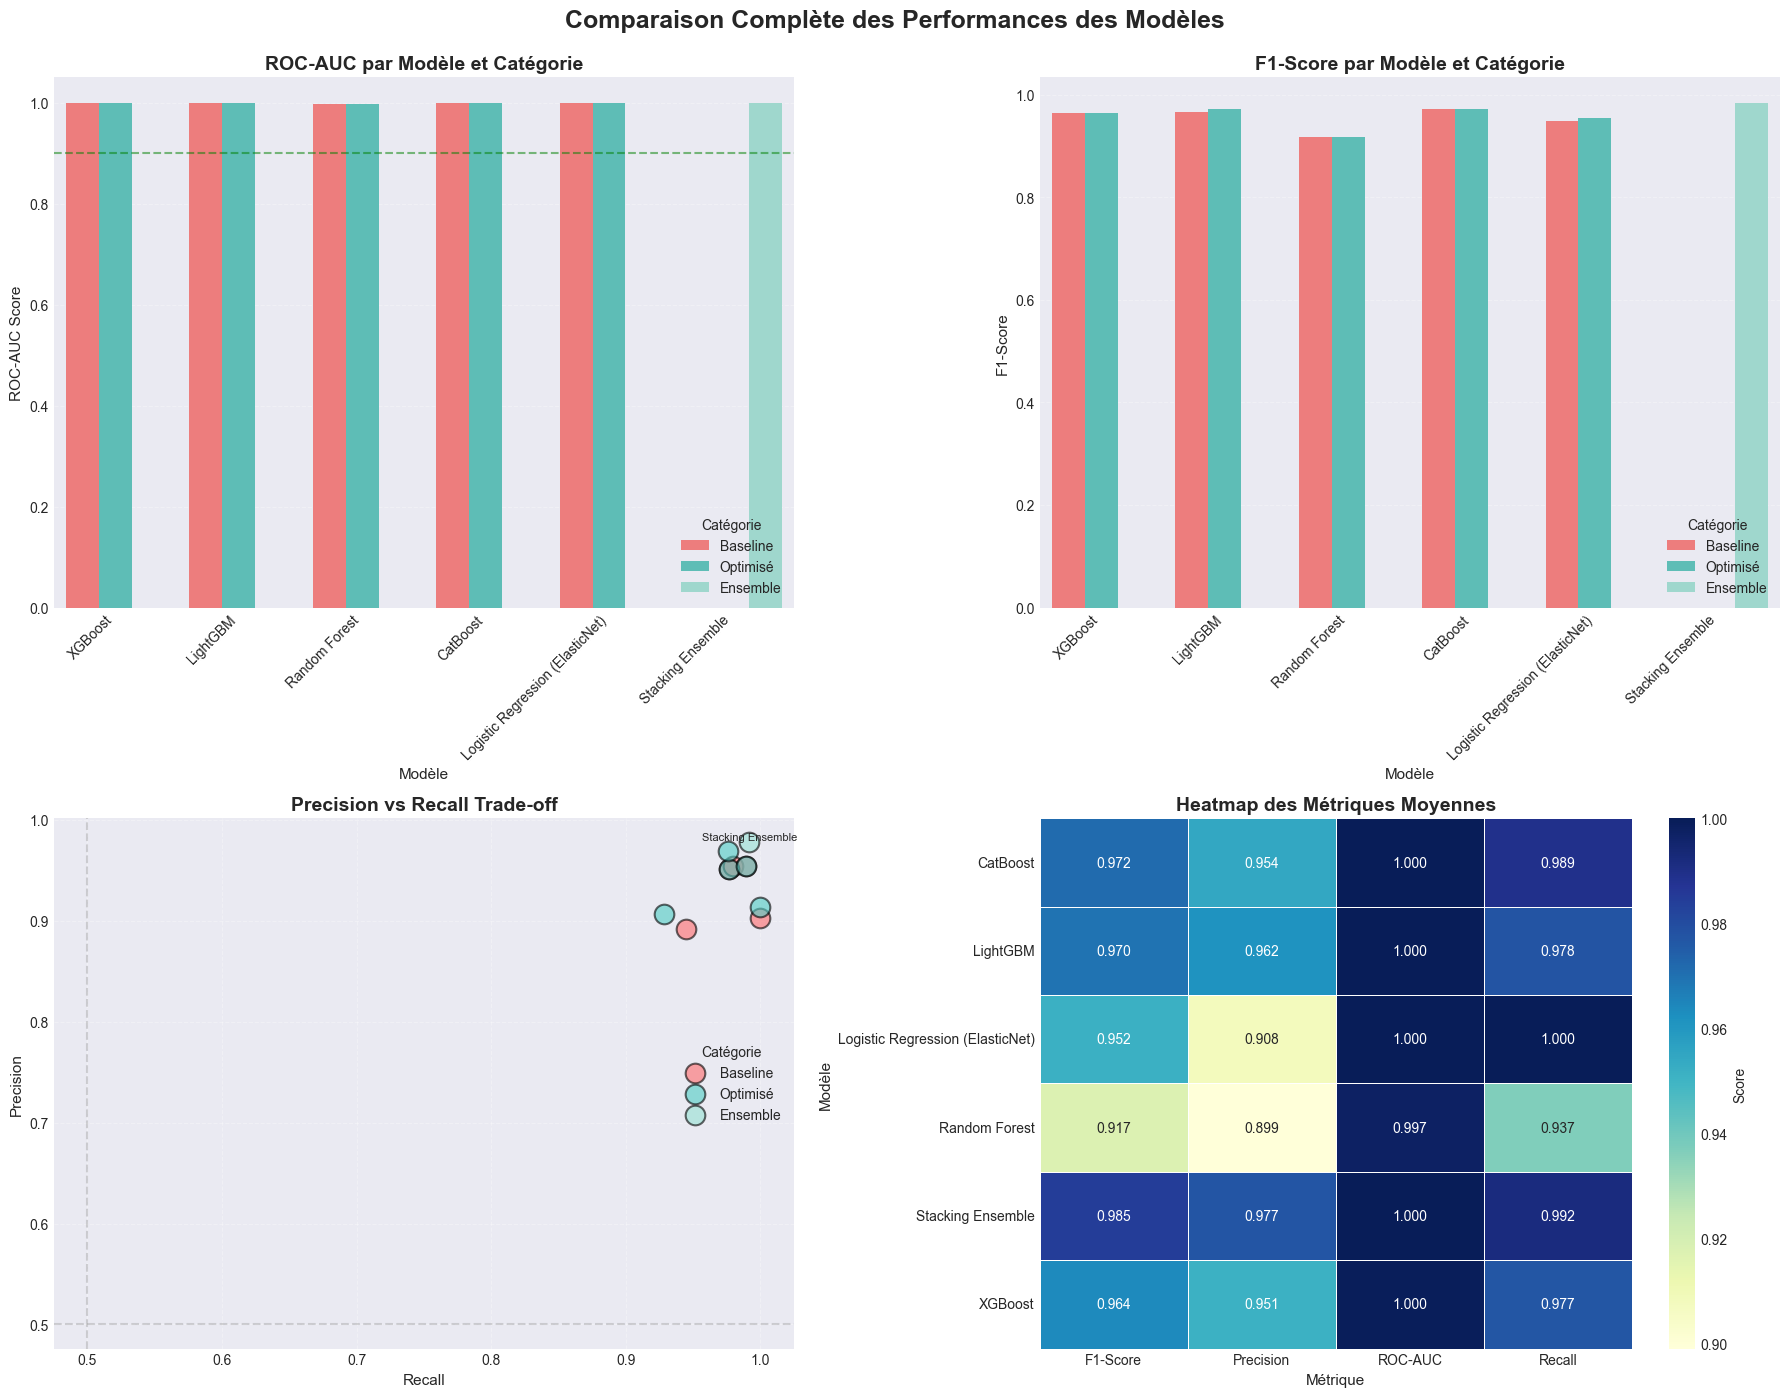

In [14]:
# 8. 📈 Visualisation - Comparaison des Performances

def visualize_model_performance_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Crée des visualisations complètes pour comparer les performances des modèles
    """
    print(f"{'='*80}")
    print("🎨 GÉNÉRATION DES VISUALISATIONS COMPARATIVES")
    print(f"{'='*80}\n")
    
    # Préparation des données
    models_data = []
    
    # Baseline
    for name, metrics in baseline_results.items():
        models_data.append({
            'Modèle': name,
            'Catégorie': 'Baseline',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision'],
            'Accuracy': metrics['accuracy']
        })
    
    # Optimisés
    for name, metrics in tuned_results.items():
        models_data.append({
            'Modèle': name,
            'Catégorie': 'Optimisé',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision'],
            'Accuracy': metrics['accuracy']
        })
    
    # Ensembles
    for name, metrics in ensemble_results.items():
        models_data.append({
            'Modèle': name,
            'Catégorie': 'Ensemble',
            'ROC-AUC': metrics['roc_auc'],
            'F1-Score': metrics['f1_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision'],
            'Accuracy': metrics['accuracy']
        })
    
    df_comparison = pd.DataFrame(models_data)
    
    # Configuration de la figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Comparaison Complète des Performances des Modèles', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # Palette de couleurs personnalisée
    color_palette = {'Baseline': '#FF6B6B', 'Optimisé': '#4ECDC4', 'Ensemble': '#95E1D3'}
    
    # 1. Comparaison ROC-AUC
    ax1 = axes[0, 0]
    sns.barplot(data=df_comparison, x='Modèle', y='ROC-AUC', hue='Catégorie', 
                palette=color_palette, ax=ax1)
    ax1.set_title('ROC-AUC par Modèle et Catégorie', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Modèle', fontsize=11)
    ax1.set_ylabel('ROC-AUC Score', fontsize=11)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.legend(title='Catégorie', loc='lower right')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Excellent (0.9)')
    
    # 2. Comparaison F1-Score
    ax2 = axes[0, 1]
    sns.barplot(data=df_comparison, x='Modèle', y='F1-Score', hue='Catégorie', 
                palette=color_palette, ax=ax2)
    ax2.set_title('F1-Score par Modèle et Catégorie', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Modèle', fontsize=11)
    ax2.set_ylabel('F1-Score', fontsize=11)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(title='Catégorie', loc='lower right')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # 3. Precision vs Recall (Scatter plot)
    ax3 = axes[1, 0]
    for category, color in color_palette.items():
        category_data = df_comparison[df_comparison['Catégorie'] == category]
        ax3.scatter(category_data['Recall'], category_data['Precision'], 
                   s=200, alpha=0.6, c=color, label=category, edgecolors='black', linewidth=1.5)
    
    ax3.set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Recall', fontsize=11)
    ax3.set_ylabel('Precision', fontsize=11)
    ax3.legend(title='Catégorie')
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    ax3.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3)
    
    # Annotations pour les points
    for idx, row in df_comparison.iterrows():
        if row['Catégorie'] == 'Ensemble':
            ax3.annotate(row['Modèle'], 
                        (row['Recall'], row['Precision']),
                        fontsize=8, ha='center', va='bottom')
    
    # 4. Heatmap des métriques
    ax4 = axes[1, 1]
    metrics_pivot = df_comparison.pivot_table(
        values=['ROC-AUC', 'F1-Score', 'Recall', 'Precision'], 
        index='Modèle', 
        aggfunc='mean'
    )
    sns.heatmap(metrics_pivot, annot=True, fmt='.3f', cmap='YlGnBu', 
                ax=ax4, cbar_kws={'label': 'Score'}, linewidths=0.5)
    ax4.set_title('Heatmap des Métriques Moyennes', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Métrique', fontsize=11)
    ax4.set_ylabel('Modèle', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('png/model_performance_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Graphique 1: Comparaison des performances sauvegardé")
    plt.show()
    
    return df_comparison

# Générer les visualisations
performance_comparison_df = visualize_model_performance_comparison(
    baseline_results, 
    tuned_results, 
    ensemble_results
)

📊 GÉNÉRATION DES COURBES ROC COMPARATIVES

✅ Graphique 2: Courbes ROC comparatives sauvegardé


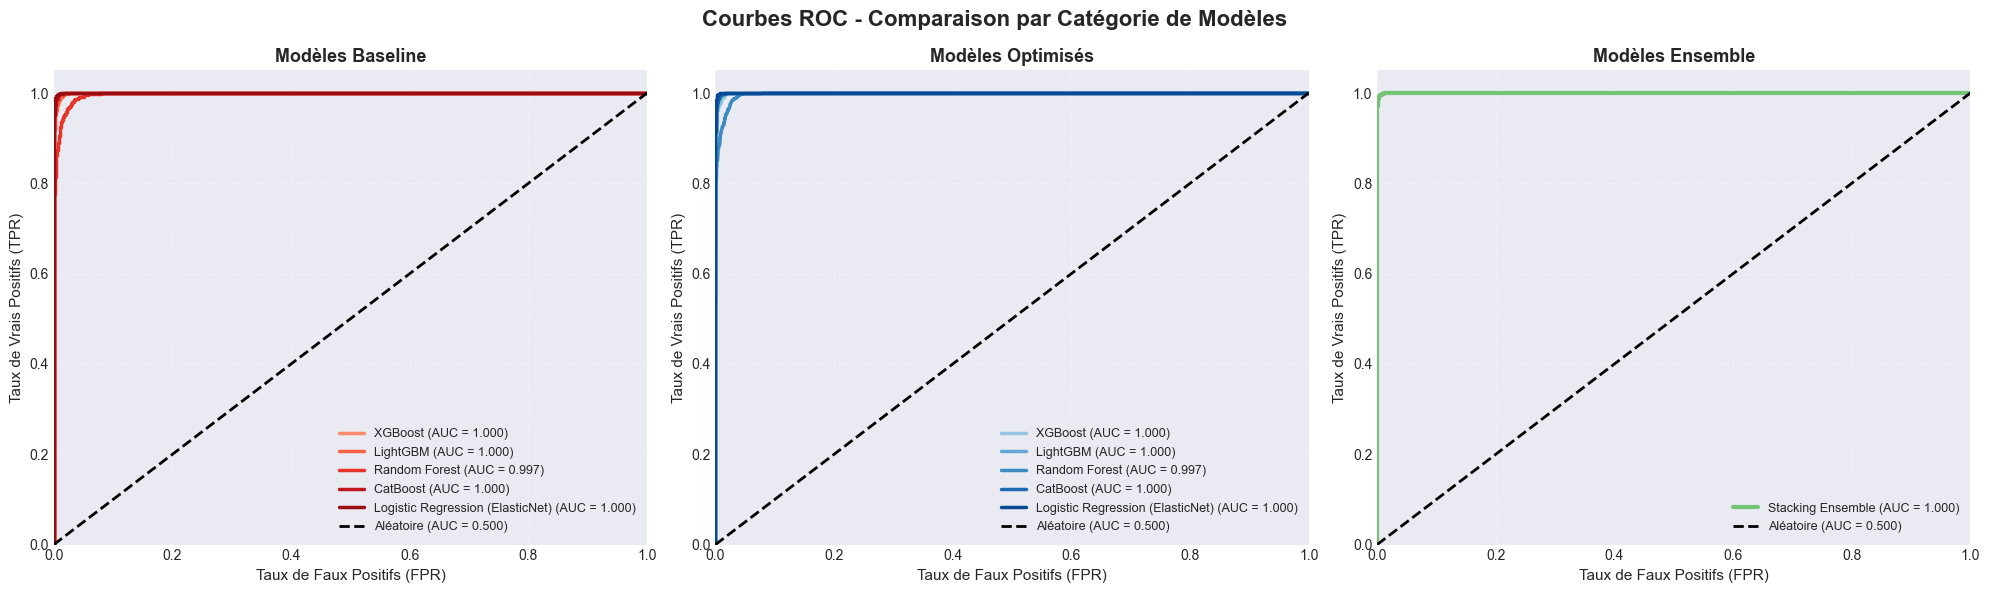

✅ Graphique 3: Vue d'ensemble des courbes ROC sauvegardé


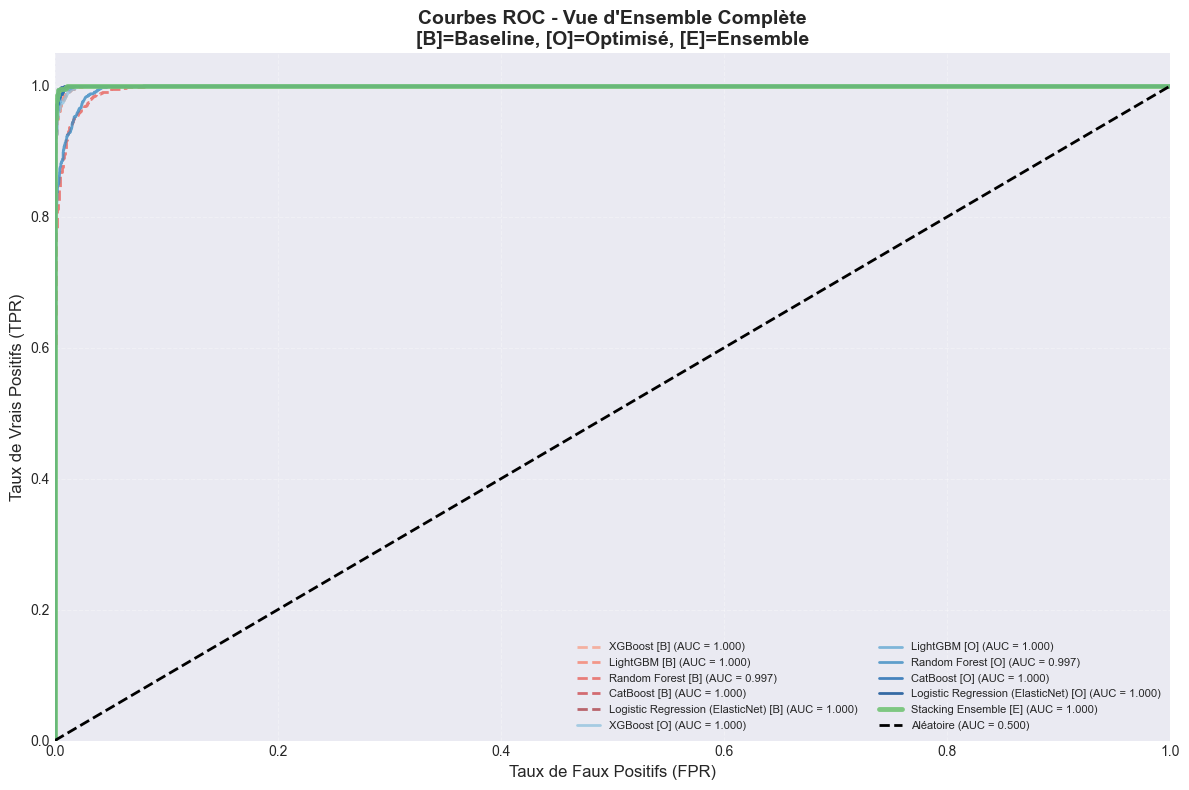

In [15]:
# 9. 📈 Courbes ROC - Comparaison Baseline vs Tuned vs Ensemble

def plot_roc_curves_comparison(baseline_results, tuned_results, ensemble_results, y_test):
    """
    Trace les courbes ROC pour tous les modèles avec comparaison visuelle
    """
    print(f"{'='*80}")
    print("📊 GÉNÉRATION DES COURBES ROC COMPARATIVES")
    print(f"{'='*80}\n")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Courbes ROC - Comparaison par Catégorie de Modèles', 
                 fontsize=16, fontweight='bold')
    
    # Définir les couleurs
    colors_baseline = plt.cm.Reds(np.linspace(0.4, 0.9, len(baseline_results)))
    colors_tuned = plt.cm.Blues(np.linspace(0.4, 0.9, len(tuned_results)))
    colors_ensemble = plt.cm.Greens(np.linspace(0.5, 0.9, len(ensemble_results)))
    
    # 1. Courbes ROC - Baseline
    ax1 = axes[0]
    for idx, (name, metrics) in enumerate(baseline_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['predictions_proba'])
        roc_auc_value = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=colors_baseline[idx], lw=2.5, 
                label=f'{name} (AUC = {roc_auc_value:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=11)
    ax1.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=11)
    ax1.set_title('Modèles Baseline', fontsize=13, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(alpha=0.3, linestyle='--')
    
    # 2. Courbes ROC - Optimisés
    ax2 = axes[1]
    for idx, (name, metrics) in enumerate(tuned_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['test_probabilities'])
        roc_auc_value = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color=colors_tuned[idx], lw=2.5, 
                label=f'{name} (AUC = {roc_auc_value:.3f})')
    
    ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=11)
    ax2.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=11)
    ax2.set_title('Modèles Optimisés', fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(alpha=0.3, linestyle='--')
    
    # 3. Courbes ROC - Ensembles
    ax3 = axes[2]
    for idx, (name, metrics) in enumerate(ensemble_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['prediction_probas'])
        roc_auc_value = auc(fpr, tpr)
        ax3.plot(fpr, tpr, color=colors_ensemble[idx], lw=3, 
                label=f'{name} (AUC = {roc_auc_value:.3f})')
    
    ax3.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=11)
    ax3.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=11)
    ax3.set_title('Modèles Ensemble', fontsize=13, fontweight='bold')
    ax3.legend(loc='lower right', fontsize=9)
    ax3.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('png/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Graphique 2: Courbes ROC comparatives sauvegardé")
    plt.show()
    
    # Graphique bonus: Toutes les courbes ROC sur un seul plot
    plt.figure(figsize=(12, 8))
    
    # Baseline
    for idx, (name, metrics) in enumerate(baseline_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['predictions_proba'])
        roc_auc_value = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors_baseline[idx], lw=2, alpha=0.6,
                linestyle='--', label=f'{name} [B] (AUC = {roc_auc_value:.3f})')
    
    # Optimisés
    for idx, (name, metrics) in enumerate(tuned_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['test_probabilities'])
        roc_auc_value = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors_tuned[idx], lw=2, alpha=0.8,
                label=f'{name} [O] (AUC = {roc_auc_value:.3f})')
    
    # Ensembles (en gras)
    for idx, (name, metrics) in enumerate(ensemble_results.items()):
        fpr, tpr, _ = roc_curve(y_test, metrics['prediction_probas'])
        roc_auc_value = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors_ensemble[idx], lw=3.5, alpha=0.9,
                label=f'{name} [E] (AUC = {roc_auc_value:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
    plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
    plt.title('Courbes ROC - Vue d\'Ensemble Complète\n[B]=Baseline, [O]=Optimisé, [E]=Ensemble', 
             fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=8, ncol=2)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('png/roc_curves_all_models.png', dpi=300, bbox_inches='tight')
    print("✅ Graphique 3: Vue d'ensemble des courbes ROC sauvegardé")
    plt.show()

# Tracer les courbes ROC
plot_roc_curves_comparison(baseline_results, tuned_results, ensemble_results, y_test)

🔬 ANALYSE DÉTAILLÉE DES AMÉLIORATIONS

✅ Graphique 4: Analyse des améliorations sauvegardé


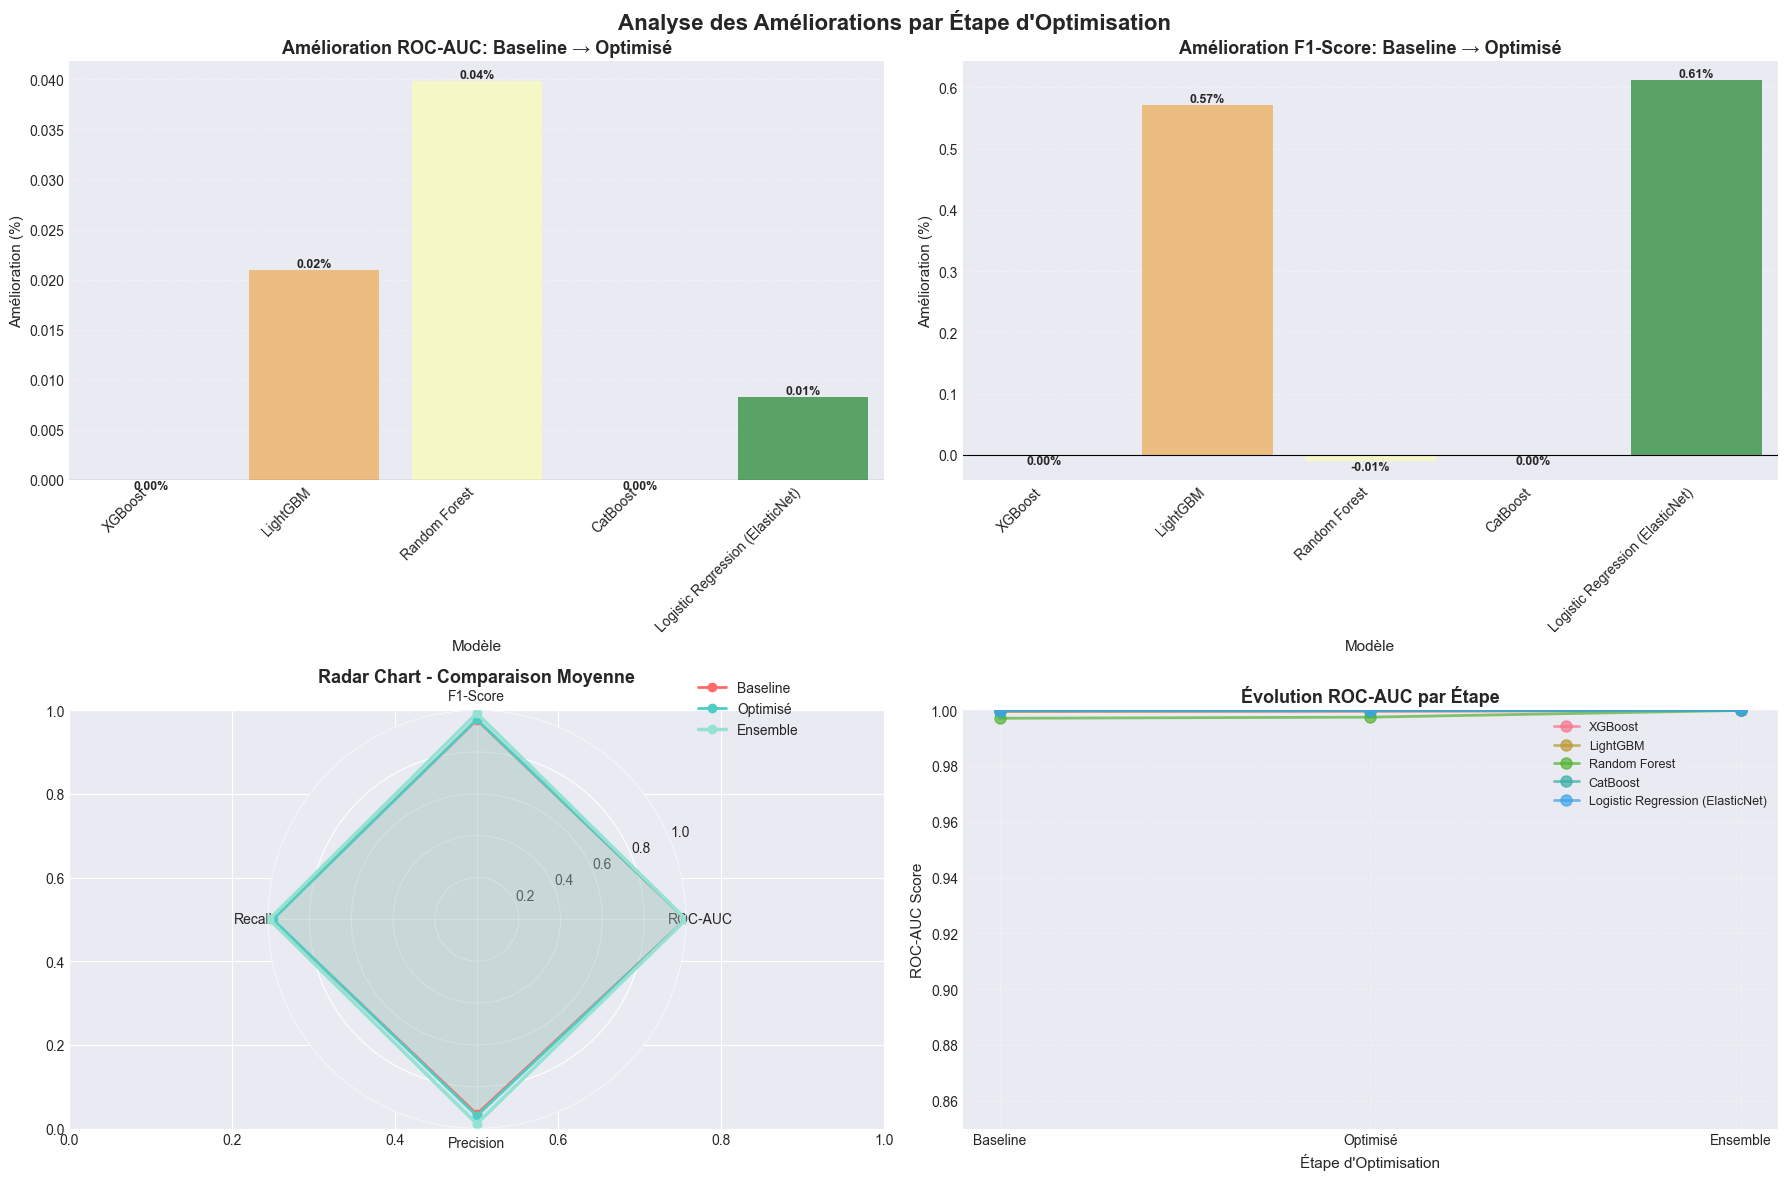


📋 TABLEAU RÉCAPITULATIF DES AMÉLIORATIONS

                          Modèle                   Transition  Δ ROC-AUC (%)  Δ F1-Score (%)  Δ Recall (%)  Δ Precision (%)  ROC-AUC Final
                         XGBoost          Baseline → Optimisé       0.000000        0.000000      0.000000         0.000000       0.999531
                        LightGBM          Baseline → Optimisé       0.020940        0.571665     -0.404858         1.516102       0.999744
                   Random Forest          Baseline → Optimisé       0.039814       -0.009786     -1.619433         1.473612       0.997474
                        CatBoost          Baseline → Optimisé       0.000000        0.000000      0.000000         0.000000       0.999789
Logistic Regression (ElasticNet)          Baseline → Optimisé       0.008263        0.611330      0.000000         1.112895       0.999900
                         XGBoost Optimisé → Stacking Ensemble       0.035156        2.054684      1.484480         2.60138

In [16]:
# 10. 📊 Analyse des Améliorations

def analyze_improvements(baseline_results, tuned_results, ensemble_results):
    """
    Analyse détaillée des améliorations entre baseline, optimisé et ensemble
    """
    print(f"{'='*80}")
    print("🔬 ANALYSE DÉTAILLÉE DES AMÉLIORATIONS")
    print(f"{'='*80}\n")
    
    improvements_data = []
    
    # Calcul des améliorations Baseline -> Optimisé
    for model_name in baseline_results.keys():
        if model_name in tuned_results:
            baseline_metrics = baseline_results[model_name]
            tuned_metrics = tuned_results[model_name]
            
            improvements = {
                'Modèle': model_name,
                'Transition': 'Baseline → Optimisé',
                'Δ ROC-AUC (%)': (tuned_metrics['roc_auc'] - baseline_metrics['roc_auc']) * 100,
                'Δ F1-Score (%)': (tuned_metrics['f1_score'] - baseline_metrics['f1_score']) * 100,
                'Δ Recall (%)': (tuned_metrics['recall'] - baseline_metrics['recall']) * 100,
                'Δ Precision (%)': (tuned_metrics['precision'] - baseline_metrics['precision']) * 100,
                'ROC-AUC Final': tuned_metrics['roc_auc']
            }
            improvements_data.append(improvements)
    
    # Comparaison Optimisé vs Meilleur Ensemble
    best_ensemble_name = max(ensemble_results, key=lambda x: ensemble_results[x]['roc_auc'])
    best_ensemble_metrics = ensemble_results[best_ensemble_name]
    
    for model_name in tuned_results.keys():
        tuned_metrics = tuned_results[model_name]
        
        improvements = {
            'Modèle': model_name,
            'Transition': f'Optimisé → {best_ensemble_name}',
            'Δ ROC-AUC (%)': (best_ensemble_metrics['roc_auc'] - tuned_metrics['roc_auc']) * 100,
            'Δ F1-Score (%)': (best_ensemble_metrics['f1_score'] - tuned_metrics['f1_score']) * 100,
            'Δ Recall (%)': (best_ensemble_metrics['recall'] - tuned_metrics['recall']) * 100,
            'Δ Precision (%)': (best_ensemble_metrics['precision'] - tuned_metrics['precision']) * 100,
            'ROC-AUC Final': best_ensemble_metrics['roc_auc']
        }
        improvements_data.append(improvements)
    
    improvements_df = pd.DataFrame(improvements_data)
    
    # Visualisation des améliorations
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Analyse des Améliorations par Étape d\'Optimisation', 
                 fontsize=16, fontweight='bold')
    
    # 1. Améliorations ROC-AUC
    ax1 = axes[0, 0]
    baseline_to_tuned = improvements_df[improvements_df['Transition'] == 'Baseline → Optimisé']
    sns.barplot(data=baseline_to_tuned, x='Modèle', y='Δ ROC-AUC (%)', 
                palette='RdYlGn', ax=ax1)
    ax1.set_title('Amélioration ROC-AUC: Baseline → Optimisé', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Modèle', fontsize=11)
    ax1.set_ylabel('Amélioration (%)', fontsize=11)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Annotations
    for i, bar in enumerate(ax1.patches):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')
    
    # 2. Améliorations F1-Score
    ax2 = axes[0, 1]
    sns.barplot(data=baseline_to_tuned, x='Modèle', y='Δ F1-Score (%)', 
                palette='RdYlGn', ax=ax2)
    ax2.set_title('Amélioration F1-Score: Baseline → Optimisé', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Modèle', fontsize=11)
    ax2.set_ylabel('Amélioration (%)', fontsize=11)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    for i, bar in enumerate(ax2.patches):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')
    
    # 3. Radar Chart - Comparaison moyenne
    ax3 = axes[1, 0]
    
    categories = ['ROC-AUC', 'F1-Score', 'Recall', 'Precision']
    
    baseline_avg = [
        np.mean([m['roc_auc'] for m in baseline_results.values()]),
        np.mean([m['f1_score'] for m in baseline_results.values()]),
        np.mean([m['recall'] for m in baseline_results.values()]),
        np.mean([m['precision'] for m in baseline_results.values()])
    ]
    
    tuned_avg = [
        np.mean([m['roc_auc'] for m in tuned_results.values()]),
        np.mean([m['f1_score'] for m in tuned_results.values()]),
        np.mean([m['recall'] for m in tuned_results.values()]),
        np.mean([m['precision'] for m in tuned_results.values()])
    ]
    
    ensemble_avg = [
        np.mean([m['roc_auc'] for m in ensemble_results.values()]),
        np.mean([m['f1_score'] for m in ensemble_results.values()]),
        np.mean([m['recall'] for m in ensemble_results.values()]),
        np.mean([m['precision'] for m in ensemble_results.values()])
    ]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    baseline_avg += baseline_avg[:1]
    tuned_avg += tuned_avg[:1]
    ensemble_avg += ensemble_avg[:1]
    angles += angles[:1]
    
    ax3 = plt.subplot(2, 2, 3, projection='polar')
    ax3.plot(angles, baseline_avg, 'o-', linewidth=2, label='Baseline', color='#FF6B6B')
    ax3.fill(angles, baseline_avg, alpha=0.15, color='#FF6B6B')
    ax3.plot(angles, tuned_avg, 'o-', linewidth=2, label='Optimisé', color='#4ECDC4')
    ax3.fill(angles, tuned_avg, alpha=0.15, color='#4ECDC4')
    ax3.plot(angles, ensemble_avg, 'o-', linewidth=2.5, label='Ensemble', color='#95E1D3')
    ax3.fill(angles, ensemble_avg, alpha=0.2, color='#95E1D3')
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories)
    ax3.set_ylim(0, 1)
    ax3.set_title('Radar Chart - Comparaison Moyenne', fontsize=13, fontweight='bold', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax3.grid(True)
    
    # 4. Timeline des améliorations
    ax4 = axes[1, 1]
    
    for model_name in baseline_results.keys():
        if model_name in tuned_results:
            stages = ['Baseline', 'Optimisé', 'Ensemble']
            roc_scores = [
                baseline_results[model_name]['roc_auc'],
                tuned_results[model_name]['roc_auc'],
                best_ensemble_metrics['roc_auc']
            ]
            ax4.plot(stages, roc_scores, marker='o', linewidth=2, markersize=8, 
                    label=model_name, alpha=0.7)
    
    ax4.set_title('Évolution ROC-AUC par Étape', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Étape d\'Optimisation', fontsize=11)
    ax4.set_ylabel('ROC-AUC Score', fontsize=11)
    ax4.legend(loc='best', fontsize=9)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_ylim([0.85, 1.0])
    
    plt.tight_layout()
    plt.savefig('png/improvements_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Graphique 4: Analyse des améliorations sauvegardé")
    plt.show()
    
    # Tableau récapitulatif
    print(f"\n{'='*80}")
    print("📋 TABLEAU RÉCAPITULATIF DES AMÉLIORATIONS")
    print(f"{'='*80}\n")
    print(improvements_df.to_string(index=False))
    
    # Statistiques globales
    print(f"\n{'='*80}")
    print("📊 STATISTIQUES GLOBALES")
    print(f"{'='*80}")
    
    avg_improvement_roc = baseline_to_tuned['Δ ROC-AUC (%)'].mean()
    avg_improvement_f1 = baseline_to_tuned['Δ F1-Score (%)'].mean()
    
    print(f"\n🎯 Amélioration moyenne Baseline → Optimisé:")
    print(f"   • ROC-AUC: {avg_improvement_roc:+.2f}%")
    print(f"   • F1-Score: {avg_improvement_f1:+.2f}%")
    
    best_improvement_model = baseline_to_tuned.loc[baseline_to_tuned['Δ ROC-AUC (%)'].idxmax()]
    print(f"\n🏆 Meilleure amélioration:")
    print(f"   • Modèle: {best_improvement_model['Modèle']}")
    print(f"   • Gain ROC-AUC: {best_improvement_model['Δ ROC-AUC (%)']:+.2f}%")
    
    print(f"\n{'='*80}\n")
    
    return improvements_df

# Analyser les améliorations
improvements_analysis_df = analyze_improvements(baseline_results, tuned_results, ensemble_results)

In [17]:
# 11. 💾 Sauvegarde du Meilleur Modèle Final

def save_champion_model(baseline_results, tuned_results, ensemble_results, 
                        optimized_models, ensemble_models, tuning_results, 
                        save_directory=PROCESSOR_DIR):
    """
    Identifie et sauvegarde le modèle champion avec toutes ses métadonnées
    
    Args:
        baseline_results: Résultats des modèles baseline
        tuned_results: Résultats des modèles optimisés
        ensemble_results: Résultats des modèles ensemble
        optimized_models: Dictionnaire des modèles optimisés
        ensemble_models: Dictionnaire des modèles ensemble
        tuning_results: Résultats de l'optimisation
        save_directory: Répertoire de sauvegarde
    
    Returns:
        Tuple contenant le nom, le modèle et les métadonnées du champion
    """
    print(f"{'='*80}")
    print("💾 IDENTIFICATION ET SAUVEGARDE DU MODÈLE CHAMPION")
    print(f"{'='*80}\n")
    
    # Consolidation de tous les résultats et modèles
    complete_results = {}
    complete_models = {}
    model_categories = {}
    
    # Étape 1: Agrégation des modèles baseline
    print("📦 Consolidation des résultats...")
    for model_name, metrics in baseline_results.items():
        full_name = f"{model_name} [Baseline]"
        complete_results[full_name] = metrics
        complete_models[full_name] = metrics['model_object']
        model_categories[full_name] = 'Baseline'
    
    # Étape 2: Agrégation des modèles optimisés
    for model_name, metrics in tuned_results.items():
        full_name = f"{model_name} [Optimisé]"
        complete_results[full_name] = metrics
        complete_models[full_name] = optimized_models[model_name]
        model_categories[full_name] = 'Optimisé'
    
    # Étape 3: Agrégation des modèles ensemble
    for model_name, metrics in ensemble_results.items():
        complete_results[model_name] = metrics
        complete_models[model_name] = ensemble_models[model_name]
        model_categories[model_name] = 'Ensemble'
    
    print(f"   ✓ {len(complete_results)} modèles consolidés\n")
    
    # Identification du champion basé sur ROC-AUC
    print("🔍 Identification du modèle champion...")
    champion_name = max(complete_results.items(), key=lambda x: x[1]['roc_auc'])[0]
    champion_model = complete_models[champion_name]
    champion_metrics = complete_results[champion_name]
    champion_category = model_categories[champion_name]
    
    print(f"\n{'─'*80}")
    print(f"🏆 MODÈLE CHAMPION IDENTIFIÉ: {champion_name}")
    print(f"{'─'*80}")
    print(f"   Catégorie:   {champion_category}")
    print(f"   ROC-AUC:     {champion_metrics['roc_auc']:.4f}")
    print(f"   F1-Score:    {champion_metrics['f1_score']:.4f}")
    print(f"   Recall:      {champion_metrics['recall']:.4f}")
    print(f"   Precision:   {champion_metrics['precision']:.4f}")
    print(f"   Accuracy:    {champion_metrics['accuracy']:.4f}")
    
    # Calcul du gain par rapport au baseline
    base_model_name = champion_name.split(' [')[0]
    if base_model_name in baseline_results:
        baseline_roc = baseline_results[base_model_name]['roc_auc']
        improvement = (champion_metrics['roc_auc'] - baseline_roc) * 100
        print(f"   Amélioration: {improvement:+.2f}% vs Baseline")
    print(f"{'─'*80}\n")
    
    # Création de la structure de sauvegarde
    models_save_dir = os.path.join(save_directory, 'trained_models')
    os.makedirs(models_save_dir, exist_ok=True)
    
    print("💾 Sauvegarde en cours...")
    
    # Sauvegarde du modèle champion
    champion_model_path = os.path.join(models_save_dir, 'champion_model.pkl')
    with open(champion_model_path, 'wb') as file:
        pickle.dump(champion_model, file)
    print(f"   ✓ Modèle champion: {champion_model_path}")
    
    # Récupération des hyperparamètres optimaux si disponible
    optimal_hyperparams = None
    if champion_category == 'Optimisé':
        base_name = champion_name.split(' [')[0]
        if base_name in tuning_results:
            optimal_hyperparams = tuning_results[base_name]['best_params']
    
    # Construction des métadonnées complètes
    champion_metadata = {
        'model_identifier': champion_name,
        'model_category': champion_category,
        'base_model_type': base_model_name,
        'performance_metrics': {
            'roc_auc_score': float(champion_metrics['roc_auc']),
            'f1_score': float(champion_metrics['f1_score']),
            'recall_score': float(champion_metrics['recall']),
            'precision_score': float(champion_metrics['precision']),
            'accuracy_score': float(champion_metrics['accuracy'])
        },
        'confusion_matrix': {
            'true_negatives': int(champion_metrics['confusion_mat'][0, 0]),
            'false_positives': int(champion_metrics['confusion_mat'][0, 1]),
            'false_negatives': int(champion_metrics['confusion_mat'][1, 0]),
            'true_positives': int(champion_metrics['confusion_mat'][1, 1])
        },
        'optimal_hyperparameters': optimal_hyperparams,
        'training_duration_seconds': champion_metrics.get('training_time', champion_metrics.get('train_time_seconds', 0)),
        'evaluation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'training_samples': len(y_train),
        'test_samples': len(y_test),
        'class_distribution': {
            'train_fraud_rate': float(y_train.mean()),
            'test_fraud_rate': float(y_test.mean())
        }
    }
    
    # Sauvegarde des métadonnées
    metadata_path = os.path.join(models_save_dir, 'champion_metadata.pkl')
    with open(metadata_path, 'wb') as file:
        pickle.dump(champion_metadata, file)
    print(f"   ✓ Métadonnées: {metadata_path}")
    
    # Sauvegarde d'une version JSON lisible
    metadata_json_path = os.path.join(models_save_dir, 'champion_metadata.json')
    import json
    
    # Conversion pour JSON (éviter les types numpy)
    json_metadata = {
        k: (v.tolist() if isinstance(v, np.ndarray) else v) 
        for k, v in champion_metadata.items()
    }
    
    with open(metadata_json_path, 'w') as file:
        json.dump(json_metadata, file, indent=4)
    print(f"   ✓ Métadonnées JSON: {metadata_json_path}")
    
    # Sauvegarde de tous les modèles optimisés (backup)
    all_optimized_path = os.path.join(models_save_dir, 'all_optimized_models.pkl')
    with open(all_optimized_path, 'wb') as file:
        pickle.dump(optimized_models, file)
    print(f"   ✓ Tous modèles optimisés: {all_optimized_path}")
    
    # Sauvegarde des modèles ensemble (backup)
    all_ensembles_path = os.path.join(models_save_dir, 'all_ensemble_models.pkl')
    with open(all_ensembles_path, 'wb') as file:
        pickle.dump(ensemble_models, file)
    print(f"   ✓ Tous modèles ensemble: {all_ensembles_path}")
    
    # Sauvegarde de l'historique complet des résultats
    complete_history = {
        'baseline_results': baseline_results,
        'tuned_results': tuned_results,
        'ensemble_results': ensemble_results,
        'tuning_history': tuning_results,
        'champion_name': champion_name
    }
    
    history_path = os.path.join(models_save_dir, 'training_history.pkl')
    with open(history_path, 'wb') as file:
        pickle.dump(complete_history, file)
    print(f"   ✓ Historique complet: {history_path}")
    
    # Génération d'un rapport de synthèse
    report_path = os.path.join(models_save_dir, 'model_report.txt')
    with open(report_path, 'w', encoding='utf-8') as file:
        file.write("="*80 + "\n")
        file.write("RAPPORT DE SYNTHÈSE - MODÈLE CHAMPION\n")
        file.write("="*80 + "\n\n")
        file.write(f"Date de génération: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        file.write(f"Modèle Champion: {champion_name}\n")
        file.write(f"Catégorie: {champion_category}\n\n")
        file.write("PERFORMANCES:\n")
        file.write(f"  • ROC-AUC:   {champion_metrics['roc_auc']:.4f}\n")
        file.write(f"  • F1-Score:  {champion_metrics['f1_score']:.4f}\n")
        file.write(f"  • Recall:    {champion_metrics['recall']:.4f}\n")
        file.write(f"  • Precision: {champion_metrics['precision']:.4f}\n")
        file.write(f"  • Accuracy:  {champion_metrics['accuracy']:.4f}\n\n")
        file.write("MATRICE DE CONFUSION:\n")
        file.write(f"  • Vrais Négatifs:  {champion_metadata['confusion_matrix']['true_negatives']:,}\n")
        file.write(f"  • Faux Positifs:   {champion_metadata['confusion_matrix']['false_positives']:,}\n")
        file.write(f"  • Faux Négatifs:   {champion_metadata['confusion_matrix']['false_negatives']:,}\n")
        file.write(f"  • Vrais Positifs:  {champion_metadata['confusion_matrix']['true_positives']:,}\n\n")
        
        if optimal_hyperparams:
            file.write("HYPERPARAMÈTRES OPTIMAUX:\n")
            for param, value in optimal_hyperparams.items():
                file.write(f"  • {param}: {value}\n")
        
        file.write("\n" + "="*80 + "\n")
    
    print(f"   ✓ Rapport de synthèse: {report_path}")
    
    print(f"\n{'='*80}")
    print(f"✅ SAUVEGARDE COMPLÉTÉE AVEC SUCCÈS")
    print(f"{'='*80}")
    print(f"📂 Répertoire: {models_save_dir}")
    print(f"📊 Total de fichiers sauvegardés: 7")
    print(f"{'='*80}\n")
    
    return champion_name, champion_model, champion_metadata

# Sauvegarder le modèle champion
champion_name, champion_model, champion_metadata = save_champion_model(
    baseline_results=baseline_results,
    tuned_results=tuned_results,
    ensemble_results=ensemble_results,
    optimized_models=optimized_models,
    ensemble_models=ensemble_models,
    tuning_results=tuning_results,
    save_directory=PROCESSOR_DIR
)

print("🎉 Processus de modélisation terminé avec succès!")

💾 IDENTIFICATION ET SAUVEGARDE DU MODÈLE CHAMPION

📦 Consolidation des résultats...
   ✓ 11 modèles consolidés

🔍 Identification du modèle champion...

────────────────────────────────────────────────────────────────────────────────
🏆 MODÈLE CHAMPION IDENTIFIÉ: Logistic Regression (ElasticNet) [Optimisé]
────────────────────────────────────────────────────────────────────────────────
   Catégorie:   Optimisé
   ROC-AUC:     0.9999
   F1-Score:    0.9549
   Recall:      1.0000
   Precision:   0.9137
   Accuracy:    0.9883
   Amélioration: +0.01% vs Baseline
────────────────────────────────────────────────────────────────────────────────

💾 Sauvegarde en cours...
   ✓ Modèle champion: processors\trained_models\champion_model.pkl
   ✓ Métadonnées: processors\trained_models\champion_metadata.pkl
   ✓ Métadonnées JSON: processors\trained_models\champion_metadata.json
   ✓ Tous modèles optimisés: processors\trained_models\all_optimized_models.pkl
   ✓ Tous modèles ensemble: processors\traine